## **Fase 1 (Parte A): Carga de Datos y Definición de Parámetros**

**Objetivo:** Preparar nuestro entorno de trabajo. En este paso, definiremos los parámetros clave que controlan nuestros algoritmos y cargaremos el archivo `resultado_geo_viviencias.csv`, convirtiéndolo en un formato geoespacial (`GeoDataFrame`) sobre el cual podamos trabajar.

**Parámetros Clave:**
* `DBSCAN_EPS`: Es la distancia máxima (en grados) que el algoritmo DBSCAN usará para buscar "vecinos". Un valor más grande incluirá más puntos en los clústers. Es el parámetro principal que ajustaremos.
* `DBSCAN_MIN_SAMPLES`: El número mínimo de puntos necesarios para ser considerado un "núcleo" denso.
* `ALPHA_VALUE`: Controla qué tan "ajustado" será el polígono final que envuelve los puntos. Un valor más bajo crea una forma más ceñida.


In [ ]:
import geopandas as gpd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
from shapely import wkt
import alphashape
from sklearn.cluster import DBSCAN
import numpy as np

In [ ]:
# -------------------------------------------------------------------
# --- PARÁMETROS DE AJUSTE (¡Puedes experimentar aquí!) ---
# -------------------------------------------------------------------
# Distancia de búsqueda de DBSCAN en grados. Aumenta este valor para hacer el clúster más grande.
# Un buen punto de partida nuevo es 0.0015 (aprox. 166 metros).
DBSCAN_EPS = 0.0020

# Mínimo de puntos para formar un clúster denso.
DBSCAN_MIN_SAMPLES = 5

# "Tensión" del polígono final. Un valor más bajo lo hace más ajustado.
ALPHA_VALUE = 0.1
# -------------------------------------------------------------------

print(f"Iniciando Fase 1 (Versión 2.4 con DBSCAN ajustable)...")
print(f"Parámetros: eps={DBSCAN_EPS}, min_samples={DBSCAN_MIN_SAMPLES}, alpha={ALPHA_VALUE}")

try:
    # --- 1. Cargar y Preparar los Datos ---
    df = pd.read_csv('resultado_geo_viviencias.csv', low_memory=False)
    df.dropna(subset=['geometry', 'Código del Campamento'], inplace=True)
    df['geometry'] = df['geometry'].apply(wkt.loads)  # Convertir WKT a geometría
    gdf_puntos = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    
    # --- 2. Calcular Polígonos con Limpieza de Outliers (DBSCAN) ---
    poligonos_lista = []
    
    for camp_code, group in gdf_puntos.groupby('Código del Campamento'):
        if len(group) < DBSCAN_MIN_SAMPLES:
            continue  # Ignorar campamentos con menos puntos que el mínimo necesario

        # Obtener las coordenadas de los puntos del campamento
        coords = np.array(list(zip(group.geometry.x, group.geometry.y)))

        # Aplicamos DBSCAN para encontrar los clústeres
        db = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES).fit(coords)
        group['cluster'] = db.labels_  # Etiquetar cada punto con su clúster

        # Filtrar los puntos que pertenecen a un clúster válido
        group_sin_ruido = group[group['cluster'] != -1]  # Los puntos etiquetados como -1 son ruido

        if group_sin_ruido.empty:
            continue  # Si no hay puntos válidos después de filtrar el ruido, continuamos con el siguiente campamento
        
        # Encontrar el clúster más grande (con mayor número de puntos)
        main_cluster_id = group_sin_ruido['cluster'].value_counts().idxmax()
        main_cluster_points = group_sin_ruido[group_sin_ruido['cluster'] == main_cluster_id]

        # Generar el polígono si el clúster tiene al menos 3 puntos
        if len(main_cluster_points) >= 3:
            try:
                # Intentamos generar el polígono utilizando Alpha Shape
                alpha_shape = alphashape.alphashape(main_cluster_points.geometry, alpha=ALPHA_VALUE)
                poligonos_lista.append({'Código del Campamento': camp_code, 'geometry': alpha_shape})
            except Exception as e:
                # Si Alpha Shape falla, usamos el Convex Hull como respaldo
                print(f"Error en Alpha Shape para campamento {camp_code}: {e}")
                convex_shape = main_cluster_points.geometry.unary_union.convex_hull
                poligonos_lista.append({'Código del Campamento': camp_code, 'geometry': convex_shape})

except Exception as e:
    print(f"Error en el procesamiento: {e}")

# --- 3. Crear un GeoDataFrame con los polígonos generados ---
gdf_poligonos = gpd.GeoDataFrame(poligonos_lista, crs="EPSG:4326")


Iniciando Fase 1 (Versión 2.4 con DBSCAN ajustable)...
Parámetros: eps=0.002, min_samples=5, alpha=0.1


## **Fase 1 (Parte B): Clustering y Generación de Polígonos**

**Objetivo:** Procesar los puntos de cada campamento para generar un único polígono que represente su huella real, ignorando los puntos atípicos (outliers) que están muy alejados.

**Proceso:**
Este bloque de código es el núcleo de la Fase 1. Hará lo siguiente para cada `Código del Campamento` único:
1.  **Agrupar:** Tomará todos los puntos que pertenecen a ese campamento.
2.  **Identificar el Núcleo (DBSCAN):** Aplicará el algoritmo DBSCAN para encontrar el grupo de puntos más denso y grande. Los puntos que estén muy lejos de este núcleo serán clasificados como "ruido" y no se usarán para crear el polígono. Esto soluciona el problema de los outliers que vimos en las imágenes.
3.  **Crear el Polígono (Alpha Shape):** Finalmente, tomará solo los puntos del "núcleo" principal y usará `alphashape` para dibujar un polígono ajustado a su forma.


In [2]:

print("Iniciando Fase 1 (Parte B): Clustering y generación de polígonos...")

try:
    poligonos_lista = []
    # Iteramos sobre cada grupo de campamento único
    for camp_code, group in gdf_puntos.groupby('Código del Campamento'):
        # Solo procesamos si el campamento tiene suficientes puntos
        if len(group) < DBSCAN_MIN_SAMPLES:
            continue

        # Extraemos las coordenadas (x, y) para que DBSCAN trabaje con ellas
        coords = np.array(list(zip(group.geometry.x, group.geometry.y)))
        
        # Aplicamos DBSCAN con los parámetros que definimos en la parte A
        db = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES).fit(coords)
        
        # Añadimos una columna 'cluster' al grupo para saber a qué cluster pertenece cada punto
        group['cluster'] = db.labels_
        
        # Filtramos los puntos clasificados como ruido (outliers), que tienen el cluster -1
        group_sin_ruido = group[group['cluster'] != -1]
        
        # Si después de quitar el ruido no quedan puntos, pasamos al siguiente campamento
        if group_sin_ruido.empty:
            continue
            
        # En caso de que DBSCAN encuentre varios clústers, nos quedamos con el más grande
        main_cluster_id = group_sin_ruido['cluster'].value_counts().idxmax()
        main_cluster_points = group_sin_ruido[group_sin_ruido['cluster'] == main_cluster_id]

        # Necesitamos al menos 3 puntos para formar un polígono
        if len(main_cluster_points) >= 3:
            try:
                # Generamos el polígono SÓLO con los puntos del clúster principal
                alpha_shape = alphashape.alphashape(main_cluster_points.geometry, alpha=ALPHA_VALUE)
                poligonos_lista.append({'Código del Campamento': camp_code, 'geometry': alpha_shape})
            except Exception:
                # Si alphashape falla por alguna razón (ej. todos los puntos en línea recta),
                # usamos el Convex Hull como un método de respaldo seguro.
                convex_shape = main_cluster_points.geometry.union_all().convex_hull
                poligonos_lista.append({'Código del Campamento': camp_code, 'geometry': convex_shape})

    # Creamos el GeoDataFrame final con los polígonos generados
    gdf_poligonos = gpd.GeoDataFrame(poligonos_lista, crs="EPSG:4326")
    
    print("\n¡ÉXITO!")
    print(f"Se generaron {len(gdf_poligonos)} polígonos de campamentos (post-limpieza de outliers).")

except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

Iniciando Fase 1 (Parte B): Clustering y generación de polígonos...

¡ÉXITO!
Se generaron 18 polígonos de campamentos (post-limpieza de outliers).


## **Fase 1 (Parte C): Guardado y Visualización de Resultados**

**Objetivo:** Guardar las geometrías que creamos para usarlas en el futuro y generar un mapa interactivo para validar visualmente nuestro trabajo.

**Proceso:**
1.  **Guardar los Polígonos:** Guardaremos nuestro `gdf_poligonos` en un archivo estándar geoespacial llamado `poligonos_campamentos_ajustados.geojson`. Este archivo es un producto muy valioso, ya que contiene las geometrías limpias que usaremos como base para las Fases 2 y 3.
2.  **Crear un Mapa Interactivo:** Generaremos un mapa HTML con la librería `Folium`. Este mapa nos permitirá inspeccionar nuestro trabajo. Dibujaremos los polígonos nuevos (en naranjo) sobre los puntos originales (en azul) para verificar si el ajuste es el correcto.

In [ ]:
# -------------------------------------------------------------------
# --- PARÁMETROS DE AJUSTE (¡Puedes experimentar aquí!) ---
# -------------------------------------------------------------------
# Distancia de búsqueda de DBSCAN en grados. Aumenta este valor para hacer el clúster más grande.
# Un buen punto de partida nuevo es 0.0015 (aprox. 166 metros).
DBSCAN_EPS = 0.0020

# Mínimo de puntos para formar un clúster denso.
DBSCAN_MIN_SAMPLES = 5

# "Tensión" del polígono final. Un valor más bajo lo hace más ajustado.
ALPHA_VALUE = 0.1
# -------------------------------------------------------------------


print(f"Iniciando Fase 1 (Versión 2.4 con DBSCAN ajustable)...")
print(f"Parámetros: eps={DBSCAN_EPS}, min_samples={DBSCAN_MIN_SAMPLES}, alpha={ALPHA_VALUE}")

try:
    # --- 1. Cargar y Preparar los Datos ---
    df = pd.read_csv('resultado_geo_viviencias.csv', low_memory=False)
    df.dropna(subset=['geometry', 'Código del Campamento'], inplace=True)
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf_puntos = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    
    # --- 2. Calcular Polígonos con Limpieza de Outliers (DBSCAN) ---
    poligonos_lista = []
    for camp_code, group in gdf_puntos.groupby('Código del Campamento'):
        if len(group) < DBSCAN_MIN_SAMPLES:
            continue

        coords = np.array(list(zip(group.geometry.x, group.geometry.y)))
        
        # Aplicamos DBSCAN con los parámetros definidos arriba
        db = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES).fit(coords)
        group['cluster'] = db.labels_
        group_sin_ruido = group[group['cluster'] != -1]
        
        if group_sin_ruido.empty:
            continue
            
        main_cluster_id = group_sin_ruido['cluster'].value_counts().idxmax()
        main_cluster_points = group_sin_ruido[group_sin_ruido['cluster'] == main_cluster_id]

        if len(main_cluster_points) >= 3:
            try:
                # Generamos el polígono SÓLO con los puntos del clúster principal
                alpha_shape = alphashape.alphashape(main_cluster_points.geometry, alpha=ALPHA_VALUE)
                poligonos_lista.append({'Código del Campamento': camp_code, 'geometry': alpha_shape})
            except Exception:
                # Si alphashape falla, usamos el Convex Hull del clúster principal como respaldo
                convex_shape = main_cluster_points.geometry.unary_union.convex_hull
                poligonos_lista.append({'Código del Campamento': camp_code, 'geometry': convex_shape})

    gdf_poligonos = gpd.GeoDataFrame(poligonos_lista, crs="EPSG:4326")
    
    print(f"Se generaron {len(gdf_poligonos)} polígonos de campamentos (post-ajuste).")

    # --- 3. Guardar y Visualizar ---
    output_geojson_path = 'poligonos_campamentos_ajustados.geojson'
    gdf_poligonos.to_file(output_geojson_path, driver='GeoJSON')
    print(f"Los polígonos se han guardado en: '{output_geojson_path}'")

    print("Creando mapa interactivo...")
    map_center = [gdf_puntos.geometry.y.mean(), gdf_puntos.geometry.x.mean()]
    mapa = folium.Map(location=map_center, zoom_start=11)

    # Polígonos en Naranjo para ver la diferencia
    folium.GeoJson(
        gdf_poligonos,
        style_function=lambda x: {'color': 'orange', 'fillColor': 'orange', 'fillOpacity': 0.4, 'weight': 2.5},
        tooltip=folium.GeoJsonTooltip(fields=['Código del Campamento'], aliases=['Campamento (Núcleo Ajustado):'])
    ).add_to(mapa)

    # Puntos originales
    for idx, row in gdf_puntos.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x], radius=1, color='blue', fill=True
        ).add_to(mapa)
    
    output_map_path = 'mapa_poligonos_campamentos_ajustados.html'
    mapa.save(output_map_path)

    print(f"\n¡ÉXITO!")
    print(f"Busca y abre el archivo '{output_map_path}' para ver el nuevo resultado.")

except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

Iniciando Fase 1 (Versión 2.4 con DBSCAN ajustable)...
Parámetros: eps=0.002, min_samples=5, alpha=0.1
Se generaron 18 polígonos de campamentos (post-ajuste).
Los polígonos se han guardado en: 'poligonos_campamentos_ajustados.geojson'
Creando mapa interactivo...

¡ÉXITO!
Busca y abre el archivo 'mapa_poligonos_campamentos_ajustados.html' para ver el nuevo resultado.


## **Fase 2: Análisis Temporal con Imágenes Satelitales**

**Objetivo:** Responder a la pregunta: **"¿Han crecido o se han densificado estos campamentos en los últimos años?"** Para esto, no nos basta con los datos que tenemos; necesitamos "viajar en el tiempo" usando imágenes satelitales.

**Metodología:**
1.  **Herramienta:** Usaremos **Google Earth Engine (GEE)**, una plataforma que nos da acceso a un catálogo inmenso de imágenes satelitales. La primera vez que lo uses, te pedirá que te autentiques con tu cuenta de Google en el navegador.
2.  **Índice:** Calcularemos el **NDBI (Índice de Zonas Construidas)**. Este índice resalta las áreas con edificios y concreto. Si el valor promedio de NDBI dentro de uno de nuestros polígonos aumentó entre el pasado (ej. 2019) y (ej. 2024), es una fuerte evidencia de que el asentamiento creció o se densificó.

El siguiente código se conectará a GEE, cargará los polígonos que acabamos de crear y calculará el cambio en la densidad de construcción para cada uno.


In [ ]:
import ee

# --- Autenticar e Inicializar Earth Engine ---
try:
    ee.Initialize()
    print("Google Earth Engine inicializado correctamente.")
except Exception as e:
    print("Autenticando con Google Earth Engine...")
    ee.Authenticate()
    ee.Initialize()

# --- Función reutilizable para Calcular NDBI Promedio ---
def calcular_ndbi_promedio(poligono_ee, anio_inicio, anio_fin):
    """Calcula el cambio de NDBI promedio para un polígono entre dos años."""
    
    def get_image(year):
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                    .filterBounds(poligono_ee) \
                    .filterDate(start_date, end_date) \
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                    .median()
        return image.normalizedDifference(['B11', 'B8']).rename('NDBI')

    ndbi_inicio = get_image(anio_inicio)
    ndbi_fin = get_image(anio_fin)
    
    cambio_ndbi = ndbi_fin.subtract(ndbi_inicio)
    
    estadisticas = cambio_ndbi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=poligono_ee,
        scale=10,
        maxPixels=1e9
    )
    return estadisticas.get('NDBI').getInfo()

# ===================================================================
# PARTE 1: ANÁLISIS PARA LOS POLÍGONOS DE CAMPAMENTOS (Rápido)
# ===================================================================
print("\n--- Iniciando Parte 1: Análisis para Campamentos ---")
resultados_campamentos = []
try:
    gdf_campamentos = gpd.read_file('poligonos_campamentos_ajustados.geojson')
    print(f"Se cargaron {len(gdf_campamentos)} polígonos de campamentos.")

    for index, row in gdf_campamentos.iterrows():
        codigo_campamento = row['Código del Campamento']
        print(f"Procesando campamento: {codigo_campamento}...")
        
        geom_json = row.geometry.__geo_interface__
        poligono_ee = ee.Geometry(geom_json)
        
        cambio = calcular_ndbi_promedio(poligono_ee, 2019, 2024)
        
        if cambio is not None:
            print(f"  -> Cambio NDBI (2019-2024): {cambio:+.4f}")
        else:
            print("  -> No se encontraron imágenes suficientes.")
            
        resultados_campamentos.append({
            'Código del Campamento': codigo_campamento,
            'Cambio_NDBI': cambio
        })

    df_resultados_camp = pd.DataFrame(resultados_campamentos)
    df_resultados_camp.to_csv('resultados_crecimiento_campamentos_ndbi.csv', index=False)
    print("\n¡ÉXITO Parte 1! Resultados de campamentos guardados en 'resultados_crecimiento_campamentos_ndbi.csv'")

except Exception as e:
    print(f"\nOcurrió un error en la Parte 1: {e}")

# ===================================================================
# PARTE 2: ANÁLISIS PARA TODOS LOS DISTRITOS (Tarea en Segundo Plano)
# ===================================================================
print("\n--- Iniciando Parte 2: Tarea de Exportación para Distritos ---")
try:
    # Cargar la FeatureCollection desde tus ASSETS de GEE
    ruta_del_asset = 'projects/ee-demardones/assets/Distrital'  # <-- ¡CAMBIA ESTA LÍNEA!
    fc_distritos = ee.FeatureCollection(ruta_del_asset)
    print(f"Asset de distritos '{ruta_del_asset}' cargado.")

    # Función para obtener la imagen de cambio de NDBI
    def obtener_imagen_cambio_ndbi(region_ee, anio_inicio, anio_fin):
        def get_image(year):
            start_date = f'{year}-01-01'; end_date = f'{year}-12-31'
            image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(region_ee).filterDate(start_date, end_date).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).median()
            return image.normalizedDifference(['B11', 'B8']).rename('NDBI')
        
        ndbi_inicio = get_image(anio_inicio)
        ndbi_fin = get_image(anio_fin)
        return ndbi_fin.subtract(ndbi_inicio).rename('Cambio_NDBI')

    # Preparar el cálculo
    region_ee = fc_distritos.geometry()
    imagen_cambio_distritos = obtener_imagen_cambio_ndbi(region_ee, 2019, 2024)
    
    resultados_distritos_ee = imagen_cambio_distritos.reduceRegions(
        collection=fc_distritos,
        reducer=ee.Reducer.mean(),
        scale=30
    )

    # Iniciar la Tarea de Exportación a Google Drive
    output_filename = 'distritos_con_cambio_ndbi'
    task = ee.batch.Export.table.toDrive(
      collection=resultados_distritos_ee,
      description='Exportar_Cambio_NDBI_por_Distrito',
      folder='GEE_Exports',
      fileNamePrefix=output_filename,
      fileFormat='CSV'
    )
    task.start()

    print(f"\n¡ÉXITO Parte 2! Se ha iniciado una tarea de exportación en GEE (ID: {task.id})")
    print("Revisa la pestaña 'Tasks' en el GEE Code Editor para ver el progreso.")

except Exception as e:
    print(f"\nOcurrió un error en la Parte 2: {e}")

Google Earth Engine inicializado correctamente.

--- Iniciando Parte 1: Análisis para Campamentos ---
Se cargaron 18 polígonos de campamentos.
Procesando campamento: 1310602...
  -> Cambio NDBI (2019-2024): -0.0312
Procesando campamento: 1311013...
  -> Cambio NDBI (2019-2024): -0.0111
Procesando campamento: 1311905...
  -> Cambio NDBI (2019-2024): +0.0112
Procesando campamento: 1311915...
  -> Cambio NDBI (2019-2024): +0.0883
Procesando campamento: 1311916...
  -> Cambio NDBI (2019-2024): +0.1132
Procesando campamento: 1312407...
  -> Cambio NDBI (2019-2024): +0.0320
Procesando campamento: 1312504...
  -> Cambio NDBI (2019-2024): -0.1009
Procesando campamento: 1312602...
  -> Cambio NDBI (2019-2024): +0.0509
Procesando campamento: 1312605...
  -> Cambio NDBI (2019-2024): -0.0034
Procesando campamento: 1312606...
  -> Cambio NDBI (2019-2024): -0.0086
Procesando campamento: 1320103...
  -> Cambio NDBI (2019-2024): +0.0246
Procesando campamento: 1320105...
  -> Cambio NDBI (2019-2024): +

In [ ]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee_image_object.getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)
folium.Map.add_ee_layer = add_ee_layer

In [ ]:

# --- Función Ayudante para añadir capas de GEE a Folium ---
# Este es el bloque que faltaba en tu código. Le "enseña" a Folium a dibujar capas de GEE.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee_image_object.getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)
folium.Map.add_ee_layer = add_ee_layer
# -----------------------------------------------------------

# --- Autenticar e Inicializar Earth Engine ---
try:
    ee.Initialize()
    print("Google Earth Engine inicializado correctamente.")
except Exception as e:
    print("Autenticando con Google Earth Engine...")
    ee.Authenticate()
    ee.Initialize()

# --- 1. Cargar el polígono del primer campamento ---
try:
    gdf_campamentos = gpd.read_file('poligonos_campamentos_ajustados.geojson').to_crs("EPSG:4326")
    # Seleccionamos el primer campamento como ejemplo
    campamento_ejemplo = gdf_campamentos.iloc[[0]] 
    codigo_campamento = campamento_ejemplo['Código del Campamento'].iloc[0]
    print(f"Visualizando el campamento de ejemplo: {codigo_campamento}")
except Exception as e:
    print(f"Error al cargar 'poligonos_campamentos_ajustados.geojson': {e}")
    exit()

# --- 2. Función para obtener la imagen NDBI para un año ---
def obtener_imagen_ndbi(poligono_ee, anio):
    fecha_inicio = f'{anio}-01-01'
    fecha_fin = f'{anio}-12-31'
    imagen = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
               .filterBounds(poligono_ee) \
               .filterDate(fecha_inicio, fecha_fin) \
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
               .median()
    ndbi = imagen.normalizedDifference(['B11', 'B8'])
    return ndbi.clip(poligono_ee) # Recortamos la imagen a nuestro polígono

# --- 3. Obtener las imágenes NDBI ---
geom_json = campamento_ejemplo.geometry.iloc[0].__geo_interface__
poligono_ee = ee.Geometry(geom_json)

ndbi_2019 = obtener_imagen_ndbi(poligono_ee, 2019)
ndbi_2024 = obtener_imagen_ndbi(poligono_ee, 2024)

# --- 4. Crear el Mapa Interactivo ---
print("Creando mapa interactivo...")
# Centramos el mapa en el campamento
map_center = [campamento_ejemplo.geometry.centroid.y.iloc[0], campamento_ejemplo.geometry.centroid.x.iloc[0]]
mapa_raster = folium.Map(location=map_center, zoom_start=16) # Aumentamos el zoom para ver detalles

# Parámetros de visualización para el NDBI (Rojo = Construido, Azul = No construido)
vis_params_ndbi = {'min': -0.5, 'max': 0.5, 'palette': ['blue', 'white', 'red']}

# Añadir las capas de GEE al mapa
mapa_raster.add_ee_layer(ndbi_2019, vis_params_ndbi, 'NDBI Campamento 2019')
mapa_raster.add_ee_layer(ndbi_2024, vis_params_ndbi, 'NDBI Campamento 2024')

# Añadir el contorno del polígono para verlo claramente
folium.GeoJson(
    campamento_ejemplo,
    style_function=lambda x: {'color': 'yellow', 'fillOpacity': 0, 'weight': 3},
    name="Contorno del Campamento"
).add_to(mapa_raster)

# Añadir control de capas
mapa_raster.add_child(folium.LayerControl())

# Guardar el mapa
output_path = 'mapa_raster_campamento.html'
mapa_raster.save(output_path)

print(f"\n¡ÉXITO! Mapa del raster del campamento guardado en: '{output_path}'")

Google Earth Engine inicializado correctamente.
Visualizando el campamento de ejemplo: 1310602
Creando mapa interactivo...


C:\Users\Diego\AppData\Local\Temp\ipykernel_11344\917566467.py:61: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [campamento_ejemplo.geometry.centroid.y.iloc[0], campamento_ejemplo.geometry.centroid.x.iloc[0]]



¡ÉXITO! Mapa del raster del campamento guardado en: 'mapa_raster_campamento.html'


In [7]:
gdf_distritos = gpd.read_file('SHP_APC2023_R13/Distrital.shp')

In [ ]:

def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee_image_object.getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)
folium.Map.add_ee_layer = add_ee_layer
# ----------------------------------------------------

# --- Script Principal ---
try:
    ee.Initialize()
    print("Google Earth Engine inicializado.")

    # --- 1. Cargar y seleccionar un distrito de ejemplo ---
    
    # ▼▼▼ ¡Pega aquí uno de los códigos que obtuviste en la Acción 1! ▼▼▼
    COD_DISTRI_A_VISUALIZAR = 9  # Por ejemplo, usando el primero de la lista
    
    gdf_distritos = gpd.read_file('SHP_APC2023_R13/Distrital.shp').to_crs("EPSG:4326")
    # Aseguramos que la columna sea de tipo numérico para la comparación
    gdf_distritos['COD_DISTRI'] = gdf_distritos['COD_DISTRI'].astype(int)
    
    distrito_ejemplo = gdf_distritos[gdf_distritos['COD_DISTRI'] == COD_DISTRI_A_VISUALIZAR]

    # Verificación para evitar el error
    if distrito_ejemplo.empty:
        print(f"Error: No se encontró el distrito con el código {COD_DISTRI_A_VISUALIZAR}. Por favor, elige otro de la lista.")
    else:
        print(f"Visualizando el distrito de ejemplo: {COD_DISTRI_A_VISUALIZAR}")

        # La función para obtener NDBI (sin cambios)
        def obtener_imagen_ndbi(poligono_ee, anio):
            fecha_inicio = f'{anio}-01-01'; fecha_fin = f'{anio}-12-31'
            imagen = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(poligono_ee).filterDate(fecha_inicio, fecha_fin).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).median()
            ndbi = imagen.normalizedDifference(['B11', 'B8'])
            return ndbi.clip(poligono_ee)

        # --- 2. Obtener imágenes y crear mapa ---
        geom_json = distrito_ejemplo.geometry.iloc[0].__geo_interface__
        poligono_ee = ee.Geometry(geom_json)
        ndbi_2019 = obtener_imagen_ndbi(poligono_ee, 2019)
        ndbi_2024 = obtener_imagen_ndbi(poligono_ee, 2024)

        map_center = [distrito_ejemplo.geometry.centroid.y.iloc[0], distrito_ejemplo.geometry.centroid.x.iloc[0]]
        mapa_raster_distrito = folium.Map(location=map_center, zoom_start=14)

        vis_params_ndbi = {'min': -0.5, 'max': 0.5, 'palette': ['blue', 'white', 'red']}
        mapa_raster_distrito.add_ee_layer(ndbi_2019, vis_params_ndbi, 'NDBI Distrito 2019')
        mapa_raster_distrito.add_ee_layer(ndbi_2024, vis_params_ndbi, 'NDBI Distrito 2024')
        folium.GeoJson(distrito_ejemplo, style_function=lambda x: {'color': 'black', 'fillOpacity': 0, 'weight': 3}, name="Contorno del Distrito").add_to(mapa_raster_distrito)
        mapa_raster_distrito.add_child(folium.LayerControl())

        output_path = 'mapa_raster_distrito.html'
        mapa_raster_distrito.save(output_path)
        print(f"\n¡ÉXITO! Mapa del raster del distrito guardado en: '{output_path}'")

except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Google Earth Engine inicializado.
Visualizando el distrito de ejemplo: 9


C:\Users\Diego\AppData\Local\Temp\ipykernel_11344\1311112670.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [distrito_ejemplo.geometry.centroid.y.iloc[0], distrito_ejemplo.geometry.centroid.x.iloc[0]]



¡ÉXITO! Mapa del raster del distrito guardado en: 'mapa_raster_distrito.html'



---
## **Fase 3: Creación del Set de Datos Final para el Modelo**

**Objetivo:** Construir nuestra tabla "maestra". Cada fila de esta tabla será un **distrito censal**, y las columnas serán todas las características que hemos preparado y calculado sobre él.

**Proceso:**
1.  **Cargar Todos los Insumos:** Cargaremos los shapefiles de Distritos y Ejes Viales, junto con los dos archivos que generamos en las fases anteriores (`poligonos_campamentos_ajustados.geojson` y `resultados_crecimiento_campamentos_ndbi.csv`).
2.  **Proyectar a un CRS Métrico:** Convertiremos todas las capas a un sistema de coordenadas que use metros (UTM, EPSG:32719) para que los cálculos de distancia y área sean precisos.
3.  **Unir y Calcular Características:** Realizaremos una serie de uniones (`joins`) para asignar a cada distrito:
    * El número de campamentos que contiene.
    * El cambio promedio de NDBI de esos campamentos.
    * La distancia a la red vial más cercana.
4.  **Guardar el Dataset Final:** El resultado será un único archivo (`dataset_listo_para_entrenar.geojson`) con toda esta inteligencia consolidada.



In [9]:
import geopandas as gpd
import pandas as pd

print("Iniciando Fase 3: Creación del set de datos para el modelo...")

# Define el CRS proyectado para Santiago (UTM Zona 19S) para cálculos en metros
CRS_PROYECTADO = "EPSG:32719"

try:
    # --- 1. Cargar todas las fuentes de datos y proyectarlas ---
    print("Cargando y proyectando archivos base...")
    # El shapefile con TODOS los distritos de tu área de estudio
    gdf_distritos = gpd.read_file('SHP_APC2023_R13/Distrital.shp').to_crs(CRS_PROYECTADO)
    
    # Las geometrías de los campamentos que creamos en Fase 1
    gdf_camp_poligonos = gpd.read_file('poligonos_campamentos_ajustados.geojson').to_crs(CRS_PROYECTADO)
    
    # La red de calles
    gdf_vial = gpd.read_file('SHP_APC2023_R13/Eje_Vial.shp').to_crs(CRS_PROYECTADO)
    
    # Los resultados del análisis de crecimiento (NDBI) de la Fase 2
    df_crecimiento = pd.read_csv('resultados_crecimiento_campamentos_ndbi.csv')

    # --- 2. Enriquecer los distritos con datos de campamentos y NDBI ---
    print("Calculando características de campamentos y NDBI por distrito...")
    
    # Unir los datos de crecimiento (NDBI) a los polígonos de campamento
    gdf_camp_poligonos = gdf_camp_poligonos.merge(df_crecimiento, on='Código del Campamento', how='left')
    
    # Unir espacialmente los campamentos (con NDBI) a los distritos
    join_dist_camp = gpd.sjoin(gdf_distritos, gdf_camp_poligonos, how='left', predicate='intersects')
    
    # Agrupar por distrito para calcular las métricas
    # Contamos campamentos únicos y calculamos el NDBI promedio
    stats_por_distrito = join_dist_camp.groupby(join_dist_camp.index).agg(
        n_campamentos=('Código del Campamento', 'nunique'),
        cambio_ndbi_promedio=('Cambio_NDBI', 'mean')
    )
    
    # Unimos las estadísticas al GeoDataFrame de distritos original
    gdf_distritos = gdf_distritos.merge(stats_por_distrito, left_index=True, right_index=True, how='left').fillna(0)

    # --- 3. Calcular distancia a la vía más cercana ---
    print("Calculando distancia a la red vial para cada distrito...")
    
    # Unificar todas las calles en una sola geometría para un cálculo más rápido
    red_vial_unificada = gdf_vial.geometry.union_all()
    
    # Calcular la distancia desde el centroide de cada distrito a la red vial unificada
    gdf_distritos['distancia_vial_m'] = gdf_distritos.geometry.centroid.apply(
        lambda punto: punto.distance(red_vial_unificada)
    )

    # --- 4. Preparar y guardar el resultado final ---
    print("Preparando y guardando el dataset final...")
    
    # Seleccionamos las columnas que usaremos en el modelo
    gdf_distritos['COD_DISTRI'] = gdf_distritos['COD_DISTRI'].astype(int)
    
    columnas_finales = [
        'COD_DISTRI', 'N_COMUNA', 'SHAPE_Area', 'SHAPE_Leng', 
        'n_campamentos', 'cambio_ndbi_promedio', 'distancia_vial_m', 
        'geometry'
    ]
    
    dataset_final = gdf_distritos[columnas_finales]
    
    # Guardar el GeoDataFrame final
    output_path = 'dataset_final_para_modelo.geojson'
    dataset_final.to_file(output_path, driver='GeoJSON')

    print(f"\n¡ÉXITO! Fase 3 completada.")
    print(f"Set de datos listo para el modelo guardado en: '{output_path}'")
    print("\nVista previa de las primeras filas del dataset final:")
    print(dataset_final.head())

except FileNotFoundError as e:
    print(f"\n--- ERROR DE ARCHIVO ---")
    print(f"No se pudo encontrar un archivo necesario: {e}")
    print("Asegúrate de que todos los archivos SHP y los resultados de las fases 1 y 2 estén disponibles.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

Iniciando Fase 3: Creación del set de datos para el modelo...
Cargando y proyectando archivos base...
Calculando características de campamentos y NDBI por distrito...
Calculando distancia a la red vial para cada distrito...
Preparando y guardando el dataset final...

¡ÉXITO! Fase 3 completada.
Set de datos listo para el modelo guardado en: 'dataset_final_para_modelo.geojson'

Vista previa de las primeras filas del dataset final:
   COD_DISTRI  N_COMUNA  SHAPE_Area  SHAPE_Leng  n_campamentos  \
0           9  SANTIAGO    0.000085    0.041509              0   
1           7  SANTIAGO    0.000053    0.032889              0   
2           8  SANTIAGO    0.000065    0.035540              0   
3           3  SANTIAGO    0.000054    0.039767              0   
4           2  SANTIAGO    0.000117    0.044109              0   

   cambio_ndbi_promedio  distancia_vial_m  \
0                   0.0         26.731173   
1                   0.0          4.283775   
2                   0.0         25.

---
### **Preparación de Datos Socioeconómicos (CASEN 2022)**

**Objetivo:** Tomar los dos archivos CSV que contienen las estimaciones de pobreza de la encuesta CASEN 2022, procesarlos para que sean utilizables, y unirlos en una única tabla (`df_casen_final`) que contenga las tasas de pobreza por comuna.

**Proceso Detallado:**

1.  **Carga de Datos:** Se cargan los dos archivos CSV (`Estimaciones_Tasa_Pobreza_Ingresos...` y `Estimaciones_Indice_Pobreza_Multidimensional...`) que ya tienes en tu entorno, especificando que se deben omitir las primeras filas de encabezado (`header=2`).

2.  **Limpieza de Pobreza por Ingresos:**
    * Se seleccionan únicamente las dos columnas que nos interesan: `'Nombre comuna'` y la columna con el porcentaje.
    * Se les cambia el nombre a unos más cortos y programáticos: `NOMBRE_COMUNA` y `tasa_pobreza_ingresos`.
    * Se transforma la columna de la tasa de pobreza (que es un texto, ej: "8,5%") a un número decimal normalizado (ej: 0.085). Para esto, se reemplaza la coma por un punto, se elimina el símbolo `%` y se divide por 100.

3.  **Limpieza de Pobreza Multidimensional:**
    * Se repite exactamente el mismo proceso de selección, renombre y conversión para el segundo archivo, creando la columna `tasa_pobreza_multi`.

4.  **Unión de las Tablas:**
    * Una vez que ambas tablas están limpias, se unen en un único DataFrame (`df_casen_final`) usando el nombre de la comuna como llave.



In [ ]:
print("Iniciando la preparación de datos socioeconómicos (CASEN 2022)...")

try:
    # --- 1. Cargar los archivos CSV originales ---
    # Asumimos que ya tienes estos DataFrames cargados.
    # Si no, descomenta estas líneas y asegúrate de que los nombres de archivo sean correctos.
    df_economico = pd.read_csv('Estimaciones_Tasa_Pobreza_Ingresos_Comunas_2022(Estimaciones).csv', encoding='latin1', header=2)
    df_economico_multidimensional = pd.read_csv('Estimaciones_Indice_Pobreza_Multidimensional_Comunas_2022 1(Estimaciones).csv', header=2, encoding='latin1')

    # --- 2. Limpiar datos de Pobreza por Ingresos ---
    print("Limpiando datos de pobreza por ingresos...")
    pobreza_ingresos = df_economico[['Nombre comuna', 'Porcentaje de personas en situación de pobreza por ingresos 2022']].copy()
    pobreza_ingresos.rename(columns={
        'Nombre comuna': 'NOMBRE_COMUNA',
        'Porcentaje de personas en situación de pobreza por ingresos 2022': 'tasa_pobreza_ingresos'
    }, inplace=True)

    # Convertir la columna de pobreza a un número (float) entre 0 y 1
    pobreza_ingresos['tasa_pobreza_ingresos'] = pobreza_ingresos['tasa_pobreza_ingresos'] \
        .astype(str) \
        .str.replace(',', '.', regex=False) \
        .str.replace('%', '', regex=False) \
        .astype(float) / 100.0
    
    # --- 3. Limpiar datos de Pobreza Multidimensional ---
    print("Limpiando datos de pobreza multidimensional...")
    # Usamos el nombre de columna correcto que identificamos previamente
    columna_correcta_multi = 'Porcentaje de personas en situación de pobreza multidimensional 2022'
    
    pobreza_multi = df_economico_multidimensional[['Nombre comuna', columna_correcta_multi]].copy()
    pobreza_multi.rename(columns={
        'Nombre comuna': 'NOMBRE_COMUNA',
        columna_correcta_multi: 'tasa_pobreza_multi'
    }, inplace=True)
    
    # Convertir la columna de pobreza a un número (float) entre 0 y 1
    pobreza_multi['tasa_pobreza_multi'] = pobreza_multi['tasa_pobreza_multi'] \
        .astype(str) \
        .str.replace(',', '.', regex=False) \
        .str.replace('%', '', regex=False) \
        .astype(float) / 100.0

    # --- 4. Unir los dos dataframes económicos en uno solo ---
    df_casen_final = pd.merge(pobreza_ingresos, pobreza_multi, on='NOMBRE_COMUNA', how='outer')
    print("Tablas económicas unificadas exitosamente.")

    # --- 5. Mostrar el resultado ---
    print("\n¡ÉXITO!")
    print("Vista previa del DataFrame con los datos de CASEN limpios y unidos:")
    print(df_casen_final.head())

except FileNotFoundError as e:
    print(f"\n--- ERROR DE ARCHIVO ---")
    print(f"No se pudo encontrar uno de los archivos CSV de CASEN: {e}")
except KeyError as e:
    print(f"\n--- ERROR DE COLUMNA ---")
    print(f"No se encontró el nombre de columna esperado: {e}. Revisa los nombres en tus archivos CSV.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

Iniciando la preparación de datos socioeconómicos (CASEN 2022)...
Limpiando datos de pobreza por ingresos...
Limpiando datos de pobreza multidimensional...
Tablas económicas unificadas exitosamente.

¡ÉXITO!
Vista previa del DataFrame con los datos de CASEN limpios y unidos:
     NOMBRE_COMUNA  tasa_pobreza_ingresos  tasa_pobreza_multi
0        Algarrobo                  0.061               0.196
1            Alhué                  0.096               0.291
2      Alto Biobío                  0.221               0.389
3  Alto Del Carmen                  0.151               0.279
4    Alto Hospicio                  0.153               0.326


¡Exacto! Ese es el último paso de la **Fase 3**. Ahora vamos a tomar nuestro GeoDataFrame de distritos y lo vamos a enriquecer con la tabla de datos socioeconómicos que acabamos de limpiar.

---
## **Fase 3 (Parte Final): Unión de Datos Socioeconómicos**

**Objetivo:** Añadir las columnas con las tasas de pobreza del DataFrame `df_casen_final` a nuestro GeoDataFrame principal `gdf_distritos`.

**Proceso:**
Lo haremos usando el nombre de la comuna como "llave" para conectar ambas tablas. Estandarizar las llaves para asegurar que coincidan perfectamente. En este caso, convertiremos los nombres de las comunas en ambas tablas a mayúsculas y les quitaremos cualquier espacio extra.

In [ ]:
print("Iniciando la unión final de datos...")

try:
    # --- Estandarizar las llaves para la unión ---
    # En gdf_distritos la columna es 'N_COMUNA'
    # En df_casen_final la columna es 'NOMBRE_COMUNA'
    
    # Limpiamos y convertimos a mayúsculas para asegurar una coincidencia perfecta
    gdf_distritos['N_COMUNA_JOIN_KEY'] = gdf_distritos['N_COMUNA'].str.strip().str.upper()
    df_casen_final['N_COMUNA_JOIN_KEY'] = df_casen_final['NOMBRE_COMUNA'].str.strip().str.upper()

    # --- Realizar la unión (merge) ---
    print("Uniendo datos CASEN al GeoDataFrame de distritos...")
    
    # Usamos pd.merge. 'how=left' para mantener todos los distritos de nuestro gdf original.
    gdf_enriquecido = pd.merge(
        gdf_distritos,
        df_casen_final,
        on='N_COMUNA_JOIN_KEY', # La llave común
        how='left'
    )
    
    # --- Limpiar y guardar ---
    # Eliminamos las columnas que ya no necesitamos
    gdf_enriquecido = gdf_enriquecido.drop(columns=['NOMBRE_COMUNA', 'N_COMUNA_JOIN_KEY'])
    
    output_path = 'dataset_listo_para_entrenar.geojson'
    gdf_enriquecido.to_file(output_path, driver='GeoJSON')
    
    print("\n¡ÉXITO! Fase 3 completada.")
    print(f"Dataset final y enriquecido guardado en: '{output_path}'")
    
    print("\nVista previa de las primeras filas del dataset final con todas las características:")
    # Mostramos las columnas más importantes para verificar
    columnas_a_mostrar = [
        'COD_DISTRI', 'N_COMUNA', 'n_campamentos', 
        'distancia_vial_m', 'tasa_pobreza_ingresos', 'tasa_pobreza_multi'
    ]
    print(gdf_enriquecido[columnas_a_mostrar].head())
    
    # Verifiquemos si alguna comuna no tuvo datos CASEN
    null_check = gdf_enriquecido['tasa_pobreza_ingresos'].isnull().sum()
    print(f"\nNúmero de distritos sin datos CASEN correspondientes: {null_check}")


except KeyError as e:
    print(f"\n--- ERROR DE COLUMNA ---")
    print(f"No se encontró el nombre de columna esperado: {e}. Asegúrate de haber ejecutado los pasos anteriores.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

Iniciando la unión final de datos...
Uniendo datos CASEN al GeoDataFrame de distritos...

¡ÉXITO! Fase 3 completada.
Dataset final y enriquecido guardado en: 'dataset_listo_para_entrenar.geojson'

Vista previa de las primeras filas del dataset final con todas las características:
   COD_DISTRI  N_COMUNA  n_campamentos  distancia_vial_m  \
0           9  SANTIAGO              0         26.731173   
1           7  SANTIAGO              0          4.283775   
2           8  SANTIAGO              0         25.124379   
3           3  SANTIAGO              0         15.179970   
4           2  SANTIAGO              0         32.363057   

   tasa_pobreza_ingresos  tasa_pobreza_multi  
0                  0.039               0.165  
1                  0.039               0.165  
2                  0.039               0.165  
3                  0.039               0.165  
4                  0.039               0.165  

Número de distritos sin datos CASEN correspondientes: 0


---
## **Fase 4 : Entrenamiento del Modelo Predictivo Enriquecido**

**Objetivo:** Utilizar nuestro set de datos final y completo para entrenar un modelo `Random Forest` robusto.

Esperamos que el rendimiento del modelo, especialmente su capacidad para detectar los distritos que sí tienen campamentos.

**El siguiente y último script hará esto:**
1.  Cargará tu `dataset` definitivo.
2.  Lo dividirá para entrenamiento y prueba.
3.  Entrenará el modelo `Random Forest`.
4.  Mostrará una evaluación completa, incluyendo qué características fueron las más importantes para su predicción.


Iniciando Fase 4 (Final): Entrenamiento del Modelo Predictivo Enriquecido...
Dataset definitivo cargado correctamente.

Usando las siguientes características para predecir: ['distancia_vial_m', 'SHAPE_Area', 'SHAPE_Leng', 'tasa_pobreza_ingresos', 'tasa_pobreza_multi', 'cambio_ndbi_promedio']
Distribución de la variable objetivo:
tiene_campamento
0    436
1     15
Name: count, dtype: int64

Datos divididos: 338 para entrenamiento, 113 para prueba.
Entrenando el modelo Random Forest...
Modelo entrenado.

--- EVALUACIÓN DEL MODELO DEFINITIVO ---

Reporte de Clasificación:
                    precision    recall  f1-score   support

Sin Campamento (0)       0.98      1.00      0.99       109
Con Campamento (1)       1.00      0.50      0.67         4

          accuracy                           0.98       113
         macro avg       0.99      0.75      0.83       113
      weighted avg       0.98      0.98      0.98       113

Generando gráfico de Matriz de Confusión...


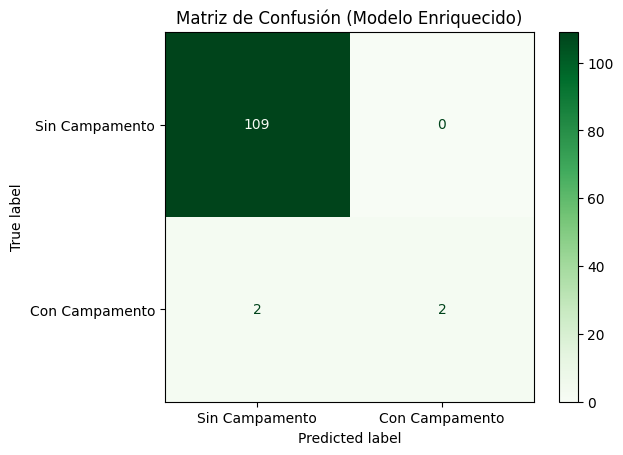


Generando gráfico de Importancia de Características...


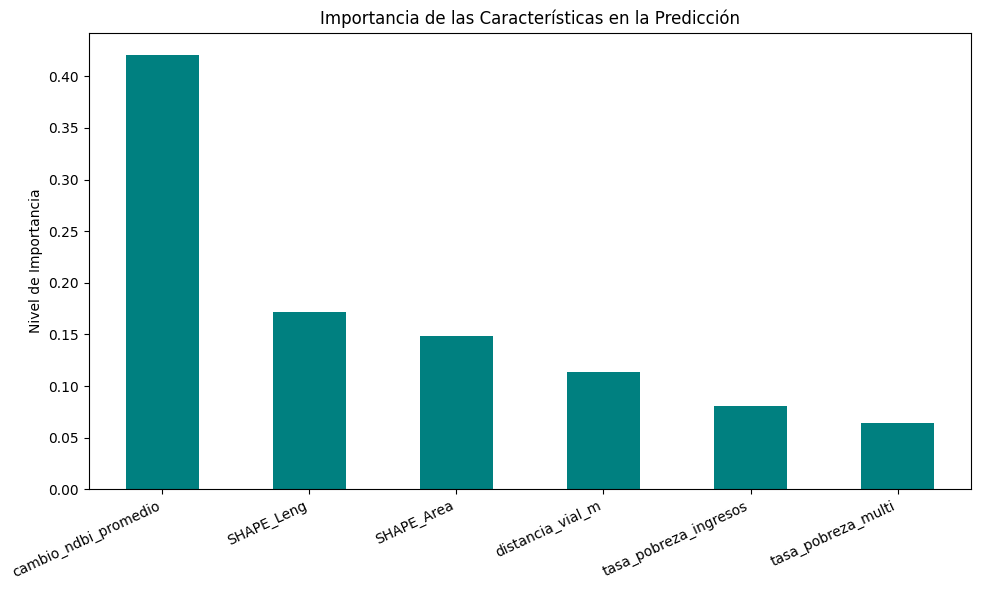


Importancia de cada característica (valores):
cambio_ndbi_promedio     0.421152
SHAPE_Leng               0.172048
SHAPE_Area               0.148466
distancia_vial_m         0.113513
tasa_pobreza_ingresos    0.080396
tasa_pobreza_multi       0.064425
dtype: float64


In [ ]:
print("Iniciando Fase 4 (Final): Entrenamiento del Modelo Predictivo Enriquecido...")

try:
    # --- 1. Cargar el set de datos final y enriquecido ---
    # Este es el archivo que contiene TODAS las características que hemos creado.
    gdf = gpd.read_file('dataset_listo_para_entrenar.geojson')
    print("Dataset definitivo cargado correctamente.")

    # --- 2. Preparar los datos para el modelo ---
    
    # Variable Objetivo 'y'
    gdf['tiene_campamento'] = (gdf['n_campamentos'] > 0).astype(int)
    y = gdf['tiene_campamento']
    
    # Variables Predictoras 'X' (¡AHORA CON TODAS LAS CARACTERÍSTICAS!)
    features = [
        'distancia_vial_m', 
        'SHAPE_Area', 
        'SHAPE_Leng', 
        'tasa_pobreza_ingresos', 
        'tasa_pobreza_multi',
        'cambio_ndbi_promedio' # Incluimos la métrica de GEE
    ]
    X = gdf[features].copy()
    
    # Manejar valores nulos que puedan quedar (ej. si una comuna no tenía datos CASEN)
    for col in X.columns:
        if X[col].isnull().any():
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)
    
    print(f"\nUsando las siguientes características para predecir: {features}")
    print(f"Distribución de la variable objetivo:\n{y.value_counts()}")

    # --- 3. Dividir los datos en entrenamiento y prueba ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    print(f"\nDatos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

    # --- 4. Entrenar el modelo Random Forest ---
    print("Entrenando el modelo Random Forest...")
    model = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    print("Modelo entrenado.")

    # --- 5. Evaluar el modelo ---
    print("\n" + "="*40)
    print("--- EVALUACIÓN DEL MODELO DEFINITIVO ---")
    print("="*40)
    y_pred = model.predict(X_test)
    
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=['Sin Campamento (0)', 'Con Campamento (1)']))

    print("Generando gráfico de Matriz de Confusión...")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sin Campamento', 'Con Campamento'])
    disp.plot(cmap='Greens')
    plt.title('Matriz de Confusión (Modelo Enriquecido)')
    plt.show()

    # --- 6. Importancia de las Características ---
    print("\nGenerando gráfico de Importancia de Características...")
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    importances.plot(kind='bar', color='teal')
    plt.title('Importancia de las Características en la Predicción')
    plt.ylabel('Nivel de Importancia')
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()
    
    print("\nImportancia de cada característica (valores):")
    print(importances)

except FileNotFoundError:
    print("\n--- ERROR ---")
    print("No se pudo encontrar el archivo 'dataset_listo_para_entrenar.geojson'.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")